In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from tqdm import tqdm
from PIL import Image
from hcmus.core import appconfig
from hcmus.lbs import LabelStudioConnector

2025-05-17 14:46:30.782 | INFO     | hcmus.core.appconfig:<module>:7 - Load DotEnv: True
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [ ]:
def fetch_backgrounds():
    result = []
    template_connector = LabelStudioConnector(
        url=appconfig.LABEL_STUDIO_URL,
        api_key=appconfig.LABEL_STUDIO_API_KEY,
        project_id=appconfig.LABEL_STUDIO_PROJECT_MAPPING["template"],
        temp_dir=appconfig.LABEL_STUDIO_TEMP_DIR
    )
    tasks = template_connector.get_tasks()
    dataset = template_connector.download_dataset(tasks)
    for item in dataset:
        img = item.get("image")
        boxes = item.get("target").get("boxes")
        result.append({
            "background": np.array(Image.open(img)),
            "boxes": boxes
        })
    return result

In [4]:
backgrounds = fetch_backgrounds()

2025-05-17 14:46:31.822 | WARNING  | hcmus.lbs._label_studio_connector:get_tasks:121 - Page size is too large, only 3 tasks available.
Loading tasks: 100%|██████████| 1/1 [00:00<00:00,  9.83it/s]
2025-05-17 14:46:31.939 | INFO     | hcmus.lbs._label_studio_connector:download_dataset:48 - No labels input, auto extract 1 labels.


In [5]:
from hcmus.utils import viz_utils

def fetch_objects():
    result = []
    train_connector = LabelStudioConnector(
        url=appconfig.LABEL_STUDIO_URL,
        api_key=appconfig.LABEL_STUDIO_API_KEY,
        project_id=appconfig.LABEL_STUDIO_PROJECT_MAPPING["train"],
        temp_dir=appconfig.LABEL_STUDIO_TEMP_DIR
    )
    tasks = train_connector.get_tasks()
    label_dict = train_connector.extract_labels(tasks)
    dataset = train_connector.download_dataset(tasks, label_dict)
    for item in tqdm(dataset, "Extract objects"):
        img = item.get("image")
        img_object = Image.open(img)
        boxes = item.get("target").get("boxes")
        crops = viz_utils.crop_image(img_object, boxes)
        labels = item.get("target").get("labels")
        for i in range(len(boxes)):
            box = boxes[i]
            crop = np.array(crops[i])
            label = labels[i]
            result.append({
                "path": img,
                "box": box,
                "object": crop,
                "label": list(label_dict.keys())[label],
                "label_id": label
            })
    return result

In [6]:
objects = fetch_objects()

2025-05-17 14:46:32.248 | WARNING  | hcmus.lbs._label_studio_connector:get_tasks:121 - Page size is too large, only 1750 tasks available.
Extract objects: 100%|██████████| 1750/1750 [00:03<00:00, 561.98it/s] 


In [7]:
len(objects)

1787

In [8]:
from hcmus.data._augment_template import AugmentTemplate

background = backgrounds[0]
background_np = background.get("background")
selected_objects = [x.get("object") for x in objects[0:10]]
selected_labels = [x.get("label") for x in objects[0:10]]
augment_template = AugmentTemplate()
new_background, new_boxes = augment_template.augment(background.get("background"), background.get("boxes"))
new_sample, fit_boxes, fit_labels = augment_template.place(new_background, new_boxes, selected_objects, selected_labels)


### Check pipeline

In [1]:
from hcmus.pipelines import yolo_augmentation_pipeline
from hcmus.data import AugmentTemplate
from hcmus.utils import viz_utils

2025-05-17 18:49:40.730 | INFO     | hcmus.core.appconfig:<module>:7 - Load DotEnv: True
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [4]:
background_project_key = "template"
object_project_key = "train"
augment_template = AugmentTemplate()
all_backgrounds = yolo_augmentation_pipeline.fetch_backgrounds(background_project_key)
all_objects, label_dict = yolo_augmentation_pipeline.fetch_objects(object_project_key)

2025-05-17 18:46:39.110 | WARNING  | hcmus.lbs._label_studio_connector:get_tasks:121 - Page size is too large, only 3 tasks available.
Loading tasks: 100%|██████████| 1/1 [00:00<00:00, 14.62it/s]
2025-05-17 18:46:39.209 | INFO     | hcmus.lbs._label_studio_connector:download_dataset:48 - No labels input, auto extract 1 labels.
2025-05-17 18:46:39.304 | WARNING  | hcmus.lbs._label_studio_connector:get_tasks:121 - Page size is too large, only 1750 tasks available.
Extract objects: 100%|██████████| 1750/1750 [00:03<00:00, 570.78it/s] 


In [6]:
image, boxes, labels = yolo_augmentation_pipeline.generate_one_sample(augment_template, all_backgrounds, all_objects)

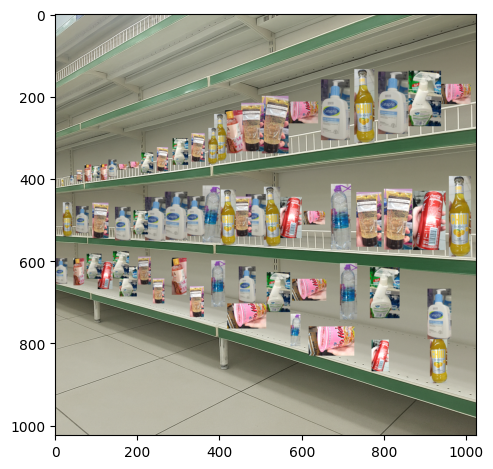

True

In [13]:
import cv2
viz_utils.plot_image(image)
image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
cv2.imwrite("temp.jpg", image_bgr)

In [2]:
yolo_augmentation_pipeline.execute(
    output_dir="local/dataset",
    n_augment=1000
)

2025-05-17 18:49:48.756 | WARNING  | hcmus.lbs._label_studio_connector:get_tasks:121 - Page size is too large, only 3 tasks available.
Loading tasks: 100%|██████████| 1/1 [00:00<00:00, 14.04it/s]
2025-05-17 18:49:48.843 | INFO     | hcmus.lbs._label_studio_connector:download_dataset:48 - No labels input, auto extract 1 labels.
2025-05-17 18:49:48.929 | WARNING  | hcmus.lbs._label_studio_connector:get_tasks:121 - Page size is too large, only 1750 tasks available.
Augmenting: 100%|██████████| 1000/1000 [01:17<00:00, 12.98it/s]
Convert to YOLO format: 1000it [00:03, 332.73it/s]
2025-05-17 18:51:16.388 | INFO     | hcmus.pipelines.yolo_augmentation_pipeline:save_yolo_v8_dataset_from_dicts:160 - YOLOv8-compatible dataset saved to: local/dataset
